# Loading Libraries

In [1]:
import pandas as pd
import numpy as np

import surprise
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k


# Reading Data

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_ratings_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (393208, 3)
Shape of Test: 	 (98401, 3)


In [4]:
# Check Head of Train
train.head()

,StockCode,CustomerID,purchased
444302,22326,14323,-1
1750,16169E,16607,1
411656,23208,15147,-1
302355,23301,12580,-1
7870,20829,17888,1


# Preparation of Train Dataset for Surprise Models


In [5]:
# Reader 
reader = surprise.Reader(rating_scale=(-2,2))

# Build Train Set from Custom Dataset
train_set = surprise.Dataset.load_from_df(train[['CustomerID', 'StockCode', 'purchased']], reader=reader).build_full_trainset()

# Baseline Model

In [6]:
# base_model
try:
    del(base_model)
except:
    pass

# Create Object for base_model 
base_model = surprise.SVDpp(random_state=0, n_factors=112, n_epochs=20, verbose=True)

# Fit the base_model
base_model.fit(train_set)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


# Prediction: Test Set Only

In [7]:
# Make Predictions
test_pred = predict(base_model, test, usercol='CustomerID', itemcol='StockCode')

# Show first five rows
test_pred.head()

,CustomerID,StockCode,prediction
0,17096,22766,-0.705524
1,15038,22478,0.898906
2,14684,21789,1.288577
3,12826,21034,-1.593510
4,15866,82600,-0.761871


In [8]:
# Check Statistics of Prediction
test_pred.prediction.describe()

count    98401.000000
mean        -0.480217
std          1.170263
min         -2.000000
25%         -1.202846
50%         -0.871576
75%          0.895582
max          2.000000
Name: prediction, dtype: float64

In [9]:
# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0),1,0)

# Convert Test
test['purchased'] = np.where((test['purchased']>0),1,0)

In [10]:
# Check Distribution
test_pred['prediction'].value_counts()

0    68875
1    29526
Name: prediction, dtype: int64

In [11]:
# Sort Index of both Datasets to use Accuracy Score 
test = test.sort_values(by=['CustomerID', 'StockCode'])
test_pred = test_pred.sort_values(by=['CustomerID', 'StockCode'])

# Reset indeces for both DataFrames
test = test.reset_index(drop=True)
test_pred = test_pred.reset_index(drop=True)

In [12]:
# First Reorder columns for test 
test = test[['CustomerID', 'StockCode', 'purchased']]
# Head of Test
test.head()

,CustomerID,StockCode,purchased
0,12347,21232,0
1,12347,21754,0
2,12347,21790,0
3,12347,22086,0
4,12347,22149,0


In [13]:
# Head of Test_pred
test_pred.head()

,CustomerID,StockCode,prediction
0,12347,21232,0
1,12347,21754,0
2,12347,21790,0
3,12347,22086,0
4,12347,22149,0


In [14]:
# Import Accuracy 
from sklearn.metrics import accuracy_score

# Accuracy 
accuracy_score(test.purchased, test_pred.prediction)

0.9362404853609211

# Prediction: Top N 

In [15]:
# Predict all pairs that are not in the train set
predictions = compute_ranking_predictions(base_model, train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)

In [16]:
# Check first five rows
predictions.head()

,CustomerID,StockCode,prediction
393208,14323,16169E,0.827617
393209,14323,20829,0.965868
393210,14323,20719,-1.061563
393211,14323,84030E,0.924936
393212,14323,84992,-0.784446


In [17]:
# Filter Test for purchased items only
test = test[test['purchased']==1]

In [18]:
# Now filter out top N 
# First write a function
def filter_top_n(predictions: pd.DataFrame, n: int) -> pd.DataFrame:
    
    # Group the dataframe by 'CustomerID', and for each group, sort by 'prediction' in descending order, then take the top N rows
    top_n_per_customer = predictions.groupby('CustomerID', group_keys=False).apply(lambda group: group.sort_values('prediction', ascending=False).head(n))
    
    return top_n_per_customer

# Filter Top 10 
top_10 = filter_top_n(predictions, 10)

# Filter Top 20 
top_20 = filter_top_n(predictions, 20)


In [19]:
# Evaluate Precision at 10 
eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('precision at 10 \t:', eval_precision_10)

# Evaluate Recall at 10 
eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
print('recall at 10 \t:', eval_recall_10)

precision at 10 	: 0.012681281618887014
recall at 10 	: 0.010419423821411537


In [20]:
# Evaluate Precision at 20 
eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('precision at 20 \t:', eval_precision_20)

# Evaluate Recall at 20 
eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
print('recall at 20 \t:', eval_recall_20)

precision at 20 	: 0.012276559865092749
recall at 20 	: 0.02117584846406726


# Hyper-Parameter Tuning

In [21]:
# Define Set of Hyperparameters: 
n_factors = [5, 10, 100, 200, 1000]

# Initiate List for Metrics
factors = []
recall_k = []

# Start for loop
for factor in n_factors:
    # First Delete Model Everytime
    try:
        del(model)
    except:
        pass

    # Define Model with Parameters 
    model = surprise.SVDpp(random_state=0, n_factors=factor, n_epochs=10)

    # Fit model
    model.fit(train_set)

    # Predict all pairs that are not in the train set
    predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')

    # Filter Top 10 
    top_10 = filter_top_n(predictions, 10)

    # Evaluate Recall at 10 
    eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)

    print("recall at for", factor, "factors: \t", eval_recall_10)

    # Append Lists
    factors.append(factor)
    recall_k.append(eval_recall_10)

recall at for 5 factors: 	 0.01126942557908799
recall at for 10 factors: 	 0.011858066801018094
recall at for 100 factors: 	 0.011168573050610428
recall at for 200 factors: 	 0.010602623692362357
recall at for 1000 factors: 	 0.006634928677239112


# Tuning 2

In [22]:
# Define Set of Hyperparameters: 
n_factors = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
lr_rates = [0.001, 0.003, 0.007]
reg_terms = [0.01, 0.02, 0.03]

# Initiate Lists 
factor_nr = []
regulation_all = []
lr_all = []
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []

# Start for loop
for factor in n_factors:
    for lr in lr_rates:
        for reg in reg_terms:
            # First Delete Model Everytime
            try:
                del(model)
            except:
                pass

            # Define Model with Parameters 
            model = surprise.SVDpp(random_state=0,
                                    n_factors=factor,
                                    n_epochs=20,
                                    lr_all=lr,
                                    reg_all=reg)

            # Fit model
            model.fit(train_set)

            # Predict all pairs that are not in the train set
            predictions = compute_ranking_predictions(model, test, usercol='CustomerID', itemcol='StockCode')

            # Filter Top 10 
            top_10 = filter_top_n(predictions, 10)
            top_20 = filter_top_n(predictions, 20)
            
            # Evaluate Recall at 10 
            eval_recall_10 = recall_at_k(test, top_10,col_user="CustomerID", col_item="StockCode",
                                        col_rating="purchased", col_prediction="prediction", 
                                        relevancy_method="top_k", k=10)
            # Evaluate Recall at 20 
            eval_recall_20 = recall_at_k(test, top_20,col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20)
            
            # Evaluate Precision at 10 
            eval_precision_10 = precision_at_k(test, top_10, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=10)
            # Evaluate Precision at 20 
            eval_precision_20 = precision_at_k(test, top_20, col_user="CustomerID", col_item="StockCode",
                                col_rating="purchased", col_prediction="prediction", 
                                relevancy_method="top_k", k=20) 
            
            print("recall at for", factor, "factors: \t", eval_recall_10)
            factor_nr.append(factor)
            regulation_all.append(reg)
            lr_all.append(lr)
            recall_10.append(eval_recall_10)
            recall_20.append(eval_recall_20)
            precision_10.append(eval_precision_10)
            precision_20.append(eval_precision_20)

recall at for 6 factors: 	 0.009297708870898199
recall at for 6 factors: 	 0.01032421461842051
recall at for 6 factors: 	 0.010377861972052394
recall at for 6 factors: 	 0.01211255443139032
recall at for 6 factors: 	 0.012091801989718768
recall at for 6 factors: 	 0.011751879357969267
recall at for 6 factors: 	 0.011951599188840414
recall at for 6 factors: 	 0.011307478917830429
recall at for 6 factors: 	 0.011362811254026753
recall at for 7 factors: 	 0.01087509339215899
recall at for 7 factors: 	 0.01148687712874402
recall at for 7 factors: 	 0.012210002659597886
recall at for 7 factors: 	 0.010832837898129609
recall at for 7 factors: 	 0.011542219960753023
recall at for 7 factors: 	 0.011528158294946208
recall at for 7 factors: 	 0.011227687576369532
recall at for 7 factors: 	 0.010877875929435997
recall at for 7 factors: 	 0.01145462320895149
recall at for 8 factors: 	 0.010477579211554441
recall at for 8 factors: 	 0.011165925091764433
recall at for 8 factors: 	 0.0116474048030712

In [36]:
dict_param2 = {
    "factor": factor_nr,
    "regulation_term": regulation_all,
    "learning_rate": lr_all,
    "recall_10": recall_10,
    "recall_20": recall_20,
    "precision_10":precision_10,
    "precision_20":precision_20
}

df_param2 = pd.DataFrame(dict_param2)
df_param2.sort_values(by="recall_20", ascending=False)

,factor,regulation_term,learning_rate,recall_10,recall_20,precision_10,precision_20
29,9,0.03,0.001,0.011121,0.023979,0.011906,0.012192
78,14,0.01,0.007,0.012356,0.023468,0.015177,0.013322
47,11,0.03,0.001,0.010718,0.023254,0.011265,0.012108
20,8,0.03,0.001,0.011647,0.023246,0.011838,0.011855
76,14,0.02,0.003,0.010325,0.023048,0.011669,0.012597
...,...,...,...,...,...,...,...
25,8,0.02,0.007,0.011101,0.019980,0.012580,0.011619
88,15,0.02,0.007,0.011442,0.019964,0.012479,0.011568
81,15,0.01,0.001,0.009613,0.019889,0.010624,0.011046
16,7,0.02,0.007,0.010878,0.019463,0.013086,0.011602


# Best Model: Accuracy on Test Set

In [26]:
# Create Object for base_model 
best_model = surprise.SVDpp(random_state=0, n_factors=14, lr_all=0.007, reg_all=0.03, n_epochs=20, verbose=False)

# Fit the base_model
best_model.fit(train_set)

# Make Predictions
test_pred = predict(base_model, test, usercol='CustomerID', itemcol='StockCode')

# Convert Predictions
test_pred['prediction'] = np.where((test_pred['prediction']>0),1,0)

# Merge test & test_pred to get positive instances 
test_positive_pred = test.merge(test_pred, on=['CustomerID', 'StockCode'], how='left', indicator=True)

# Accuracy 
accuracy_score(test_positive_pred.purchased, test_positive_pred.prediction)

0.8365952518818761

# Visualizations best Model

In [28]:
# Import Vizualization Libraries
import seaborn as sns 
from matplotlib import pyplot as plt
import plotly.express as px

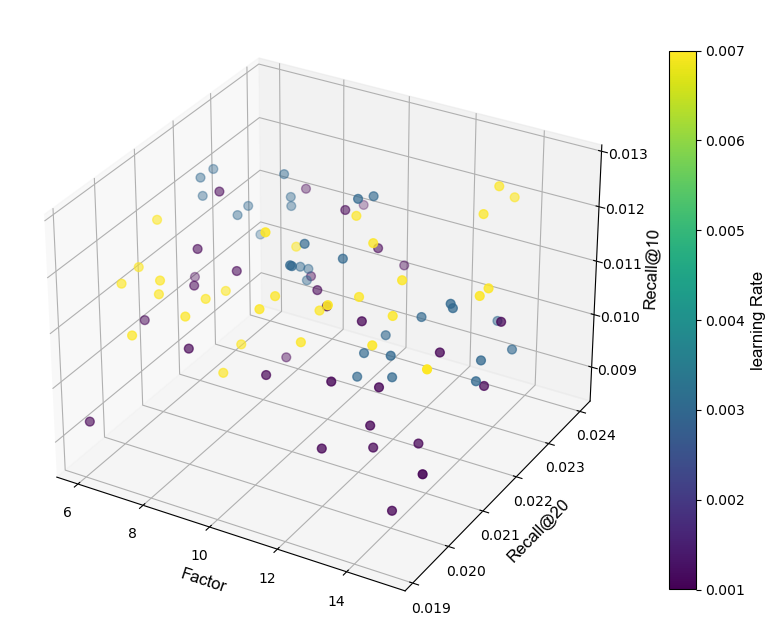

In [33]:
fig = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_param2.factor, df_param2.recall_20, df_param2.recall_10
ax.set_xlabel('Factor', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
ax.set_ylabel('Recall@20',fontname='Arial', fontsize=12)
#ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=df_param2.learning_rate)
scatter = ax.scatter(x,y,z, cmap='viridis', marker='o', s=40, c=df_param2.learning_rate)
#ax.set_title('Number of Factors in the latent Space for the NMF model', fontname='Arial', fontsize=15)

# Colorbar
cbar = plt.colorbar(scatter, shrink=0.7)
cbar.set_label('learning Rate', fontname='Arial', fontsize=12)
plt.show()


In [34]:
df_param2.groupby("regulation_term")["recall_10"].mean()

regulation_term
0.01    0.010982
0.02    0.011034
0.03    0.011338
Name: recall_10, dtype: float64

In [35]:
df_param2.groupby("learning_rate")["recall_10"].mean()

learning_rate
0.001    0.010526
0.003    0.011261
0.007    0.011568
Name: recall_10, dtype: float64